# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='../assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, CenterCrop
from torchvision.io import read_image


import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size),
                  #CenterCrop(size),
                  ToTensor(),
                  Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                 ]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.file_list = [file for file in os.listdir(directory) if file.endswith(extension)]

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.file_list)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        file_name = self.file_list[index]
        image_path = os.path.join(self.directory, file_name) 
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        
        return image

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

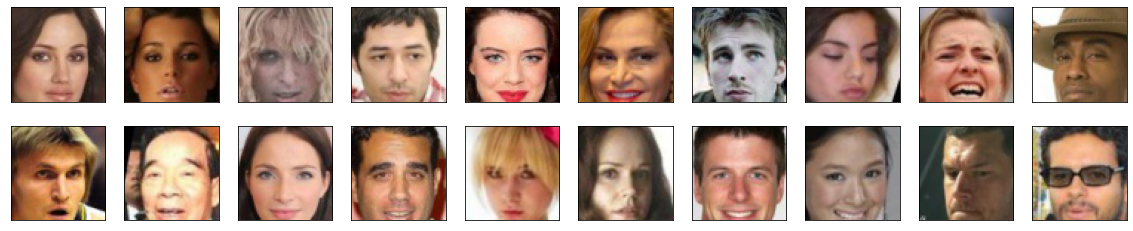

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
import torch.nn as nn
from torch.nn import Module

In [9]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 batch_norm: bool = True,  
                 batch_inst: bool = False):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        self.batch_inst = batch_inst
        
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
            
        if self.batch_inst:    
            self.inorm = nn.InstanceNorm2d(out_channels, affine=True)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        if self.batch_inst:
            x = self.inorm(x)
        x = self.activation(x)
        return x

In [10]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        
        self.conv1 = ConvBlock(3, 128, 4, batch_norm=False)                
#         self.conv2 = ConvBlock(64, 128, 4, batch_norm=True, batch_inst=False)
        self.conv2 = ConvBlock(128, 256, 4, batch_norm=True, batch_inst=False)
        self.conv3 = ConvBlock(256, 512, 4, batch_norm=True, batch_inst=False)
        self.conv4 = ConvBlock(512, 1024, 4, batch_norm=True, batch_inst=False)
        self.conv5 = nn.Conv2d(1024, 1, 4, stride=1, padding=0, bias=False)        
#         self.sigm = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)        
        x = self.conv4(x)  
        x = self.conv5(x)
#         x = self.sigm(x)
        return x

In [11]:
print(Discriminator())

Discriminator(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (conv4): ConvBlock(
    (conv): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.2)
  )
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), s

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [14]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        self.deconv1 = DeconvBlock(latent_dim, 1024, 4, 1, 0)
        self.deconv2 = DeconvBlock(1024, 512, 4, 2, 1)
        self.deconv3 = DeconvBlock(512, 256, 4, 2, 1)
        self.deconv4 = DeconvBlock(256, 128, 4, 2, 1)        
        self.deconv5 = DeconvBlock(128, 64, 4, 2, 1)
        self.deconv6 = nn.ConvTranspose2d(64, 3, 3, stride=1, padding=1, bias=False)
        self.last_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.deconv6(x)
        x = self.last_activation(x)
        return x

In [15]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [16]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=[0.4, 0.999])
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=[0.4, 0.999])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [17]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss 
#     loss = -torch.mean(fake_logits)
    
    labels = torch.ones_like(fake_logits)*0.9
#     labels = torch.ones_like(fake_logits)
    
    if device == "cuda":
        labels = labels.cuda()
            
    criterion = nn.BCEWithLogitsLoss()
#     criterion = nn.BCELoss()
    
    loss = criterion(fake_logits, labels)

    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
#     real_loss = -torch.mean(real_logits)
#     fake_loss = torch.mean(fake_logits)
#     loss = real_loss + fake_loss
    
    labels_real = torch.ones_like(real_logits)*0.9
    labels_fake = torch.zeros_like(fake_logits)*0.9
    
#     labels_real = torch.ones_like(real_logits)
#     labels_fake = torch.zeros_like(fake_logits)
    
    if device == "cuda":
        labels_real = labels_real.cuda()
        labels_fake = labels_fake.cuda()
            
    criterion = nn.BCEWithLogitsLoss()
#     criterion = nn.BCELoss()
    
    real_loss = criterion(real_logits, labels_real)
    fake_loss = criterion(fake_logits, labels_fake)
    
    loss = real_loss+fake_loss

    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    #gp = 0
    # TODO (Optional): implement the gradient penalty
    alpha = torch.rand(real_samples.shape)
    if device == "cuda":
        alpha = alpha.cuda()
        
    x_hat = alpha * real_samples + (1 - alpha) * fake_samples    
    x_hat.requires_grad = True
    if device == "cuda":
        x_hat = x_hat.cuda()    
    pred = discriminator(x_hat) 
    
    grad_out = torch.ones_like(pred)
    if device == "cuda":
        grad_out = grad_out.cuda() 
    
    grad = torch.autograd.grad(pred, 
                               x_hat, 
                               grad_outputs=grad_out, 
                               create_graph=True)[0]
    
    norm = torch.norm(grad.view(-1), 2)
    gp = ((norm - 1)**2).mean()    
    
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [20]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
        
    generator.zero_grad()
    
    #generate fake images
    # z = np.random.uniform(-1,1, size= [batch_size, latent_dim, 1, 1])
    # z = torch.from_numpy(z).float()
    # z = torch.normal(0, 0.2, size=(batch_size, latent_dim, 1, 1))
    z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    if device == "cuda":
        z = z.cuda()
        
    fake_images = generator(z)
    D_fake = discriminator(fake_images)
    g_loss = generator_loss(D_fake)
    
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    
    discriminator.zero_grad()
        
    #1. Train with real images
    # Compute the discriminator losses on real images 
    if device == "cuda":
        real_images = real_images.cuda()
    
#     print(real_images.shape)
    
    D_real = discriminator(real_images)
    
    #2. Train with fake images
    # z = np.random.uniform(-1,1, size= (batch_size, latent_dim, 1,1))
    # z = torch.from_numpy(z).float()    
    # z = torch.normal(0, 0.1, size=(batch_size, latent_dim, 1, 1))    
    z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    if device == "cuda":
        z = z.cuda()    
    
    fake_images = generator(z).detach()
    D_fake = discriminator(fake_images)
    
#     gp = gradient_penalty(discriminator, real_images.detach(), fake_images.detach())
    gp = 0
#     print(f'gradient_penalty: {gp}')
#     d_loss = discriminator_loss(D_real, D_fake) + 10 * gp
    d_loss = discriminator_loss(D_real, D_fake)
    d_loss.backward()
    d_optimizer.step()
    
    
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [21]:
from datetime import datetime

In [22]:
# you can experiment with different dimensions of latent spaces
latent_dim = 100

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 30

# number of images in each batch
batch_size = 128

# Random seed
# manualSeed = 7777
# print('Random Seed:', manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

In [25]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [26]:
initialize_weights(generator)
initialize_weights(discriminator)

2023-12-21 09:45:19 | Epoch [1/30] | Batch 0/254 | d_loss: 1.3694 | g_loss: 7.1807
2023-12-21 09:46:13 | Epoch [1/30] | Batch 50/254 | d_loss: 0.9913 | g_loss: 6.6321
2023-12-21 09:47:08 | Epoch [1/30] | Batch 100/254 | d_loss: 3.0397 | g_loss: 10.4676
2023-12-21 09:48:03 | Epoch [1/30] | Batch 150/254 | d_loss: 1.0116 | g_loss: 1.9015
2023-12-21 09:48:57 | Epoch [1/30] | Batch 200/254 | d_loss: 1.1508 | g_loss: 1.5031
2023-12-21 09:49:52 | Epoch [1/30] | Batch 250/254 | d_loss: 1.1924 | g_loss: 3.0013


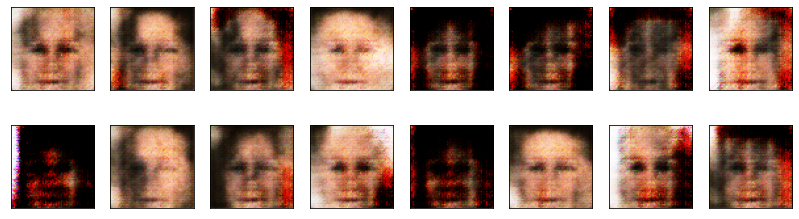

2023-12-21 09:50:00 | Epoch [2/30] | Batch 0/254 | d_loss: 1.3409 | g_loss: 2.2028
2023-12-21 09:50:55 | Epoch [2/30] | Batch 50/254 | d_loss: 1.0305 | g_loss: 1.7952
2023-12-21 09:51:49 | Epoch [2/30] | Batch 100/254 | d_loss: 1.0819 | g_loss: 2.8202
2023-12-21 09:52:43 | Epoch [2/30] | Batch 150/254 | d_loss: 1.0364 | g_loss: 2.2223
2023-12-21 09:53:38 | Epoch [2/30] | Batch 200/254 | d_loss: 0.9224 | g_loss: 2.2724
2023-12-21 09:54:32 | Epoch [2/30] | Batch 250/254 | d_loss: 1.0434 | g_loss: 1.2917


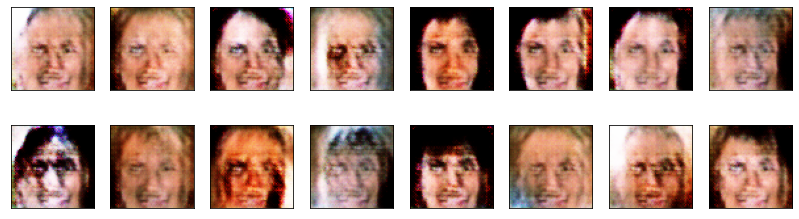

2023-12-21 09:54:40 | Epoch [3/30] | Batch 0/254 | d_loss: 1.4049 | g_loss: 1.7277
2023-12-21 09:55:35 | Epoch [3/30] | Batch 50/254 | d_loss: 1.1005 | g_loss: 4.0672
2023-12-21 09:56:29 | Epoch [3/30] | Batch 100/254 | d_loss: 0.8786 | g_loss: 2.6398
2023-12-21 09:57:23 | Epoch [3/30] | Batch 150/254 | d_loss: 1.1006 | g_loss: 2.8725
2023-12-21 09:58:18 | Epoch [3/30] | Batch 200/254 | d_loss: 1.2238 | g_loss: 2.7005
2023-12-21 09:59:12 | Epoch [3/30] | Batch 250/254 | d_loss: 1.3085 | g_loss: 1.8392


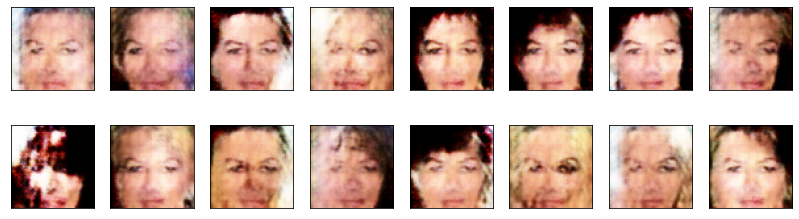

2023-12-21 09:59:20 | Epoch [4/30] | Batch 0/254 | d_loss: 1.5053 | g_loss: 3.9213
2023-12-21 10:00:15 | Epoch [4/30] | Batch 50/254 | d_loss: 1.1599 | g_loss: 2.7464
2023-12-21 10:01:09 | Epoch [4/30] | Batch 100/254 | d_loss: 0.9830 | g_loss: 2.5741
2023-12-21 10:02:03 | Epoch [4/30] | Batch 150/254 | d_loss: 0.8175 | g_loss: 2.9807
2023-12-21 10:02:58 | Epoch [4/30] | Batch 200/254 | d_loss: 1.0779 | g_loss: 0.7981
2023-12-21 10:03:52 | Epoch [4/30] | Batch 250/254 | d_loss: 0.9677 | g_loss: 2.5125


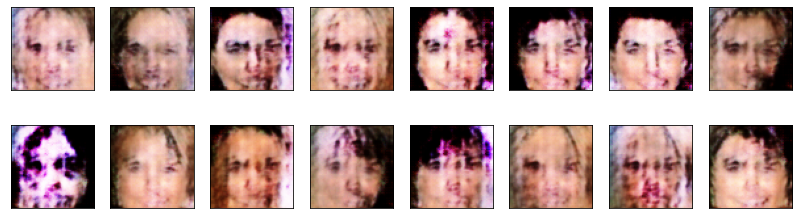

2023-12-21 10:04:00 | Epoch [5/30] | Batch 0/254 | d_loss: 0.7520 | g_loss: 2.2806
2023-12-21 10:04:55 | Epoch [5/30] | Batch 50/254 | d_loss: 1.1617 | g_loss: 2.1416
2023-12-21 10:05:49 | Epoch [5/30] | Batch 100/254 | d_loss: 3.1017 | g_loss: 2.8090
2023-12-21 10:06:43 | Epoch [5/30] | Batch 150/254 | d_loss: 1.3863 | g_loss: 1.8268
2023-12-21 10:07:38 | Epoch [5/30] | Batch 200/254 | d_loss: 0.9620 | g_loss: 2.4075
2023-12-21 10:08:32 | Epoch [5/30] | Batch 250/254 | d_loss: 0.6466 | g_loss: 2.4983


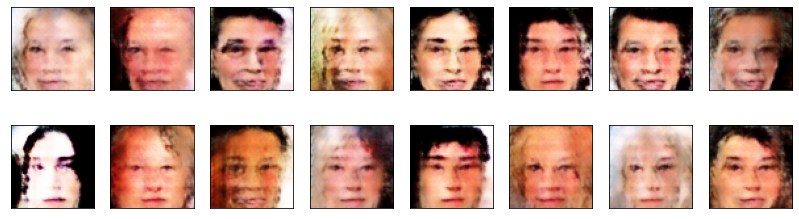

2023-12-21 10:08:40 | Epoch [6/30] | Batch 0/254 | d_loss: 2.0356 | g_loss: 6.1798
2023-12-21 10:09:34 | Epoch [6/30] | Batch 50/254 | d_loss: 0.8107 | g_loss: 0.9223
2023-12-21 10:10:29 | Epoch [6/30] | Batch 100/254 | d_loss: 1.3195 | g_loss: 2.4157
2023-12-21 10:11:23 | Epoch [6/30] | Batch 150/254 | d_loss: 1.8567 | g_loss: 0.8423
2023-12-21 10:12:18 | Epoch [6/30] | Batch 200/254 | d_loss: 0.9402 | g_loss: 1.5128
2023-12-21 10:13:13 | Epoch [6/30] | Batch 250/254 | d_loss: 1.6322 | g_loss: 0.6123


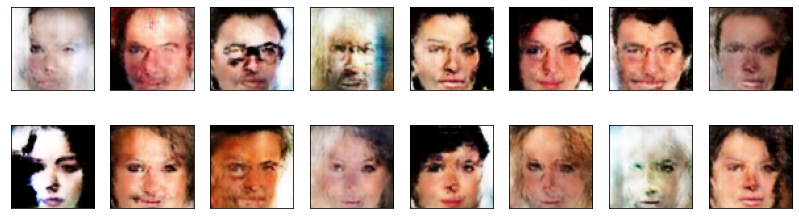

2023-12-21 10:13:21 | Epoch [7/30] | Batch 0/254 | d_loss: 1.3836 | g_loss: 2.3496
2023-12-21 10:14:15 | Epoch [7/30] | Batch 50/254 | d_loss: 0.7644 | g_loss: 3.2474
2023-12-21 10:15:10 | Epoch [7/30] | Batch 100/254 | d_loss: 0.8740 | g_loss: 2.3635
2023-12-21 10:16:04 | Epoch [7/30] | Batch 150/254 | d_loss: 1.2645 | g_loss: 1.3680
2023-12-21 10:16:58 | Epoch [7/30] | Batch 200/254 | d_loss: 0.8228 | g_loss: 2.0815
2023-12-21 10:17:53 | Epoch [7/30] | Batch 250/254 | d_loss: 0.9773 | g_loss: 1.6361


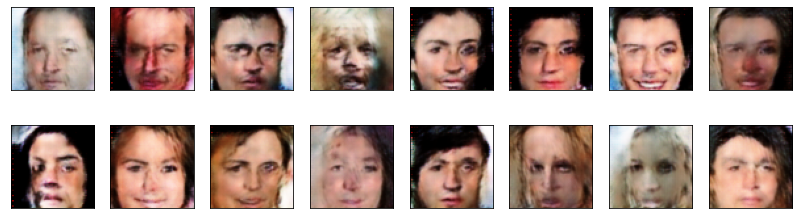

2023-12-21 10:18:02 | Epoch [8/30] | Batch 0/254 | d_loss: 0.8162 | g_loss: 1.7997
2023-12-21 10:18:57 | Epoch [8/30] | Batch 50/254 | d_loss: 1.1767 | g_loss: 1.4429
2023-12-21 10:19:51 | Epoch [8/30] | Batch 100/254 | d_loss: 1.0756 | g_loss: 1.2479
2023-12-21 10:20:46 | Epoch [8/30] | Batch 150/254 | d_loss: 1.1172 | g_loss: 1.4951
2023-12-21 10:21:41 | Epoch [8/30] | Batch 200/254 | d_loss: 0.7920 | g_loss: 2.3479
2023-12-21 10:22:35 | Epoch [8/30] | Batch 250/254 | d_loss: 1.0949 | g_loss: 1.8339


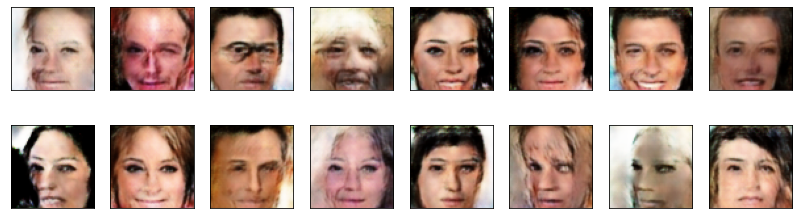

2023-12-21 10:22:43 | Epoch [9/30] | Batch 0/254 | d_loss: 0.9418 | g_loss: 3.1877
2023-12-21 10:23:38 | Epoch [9/30] | Batch 50/254 | d_loss: 1.0878 | g_loss: 1.6570
2023-12-21 10:24:32 | Epoch [9/30] | Batch 100/254 | d_loss: 1.4897 | g_loss: 1.0766
2023-12-21 10:25:26 | Epoch [9/30] | Batch 150/254 | d_loss: 0.8609 | g_loss: 2.6215
2023-12-21 10:26:21 | Epoch [9/30] | Batch 200/254 | d_loss: 0.9769 | g_loss: 2.1935
2023-12-21 10:27:15 | Epoch [9/30] | Batch 250/254 | d_loss: 1.5971 | g_loss: 1.4314


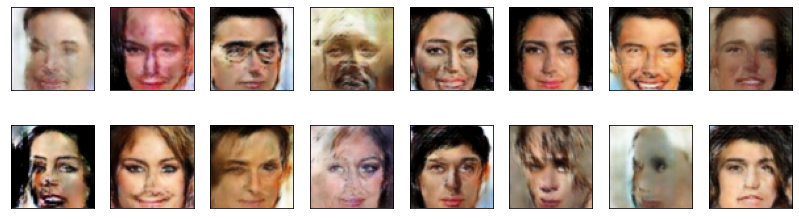

2023-12-21 10:27:24 | Epoch [10/30] | Batch 0/254 | d_loss: 0.9979 | g_loss: 1.3794
2023-12-21 10:28:19 | Epoch [10/30] | Batch 50/254 | d_loss: 1.2786 | g_loss: 3.1954
2023-12-21 10:29:13 | Epoch [10/30] | Batch 100/254 | d_loss: 0.9193 | g_loss: 2.7532
2023-12-21 10:30:08 | Epoch [10/30] | Batch 150/254 | d_loss: 1.0280 | g_loss: 2.2164
2023-12-21 10:31:02 | Epoch [10/30] | Batch 200/254 | d_loss: 1.1227 | g_loss: 2.9576
2023-12-21 10:31:57 | Epoch [10/30] | Batch 250/254 | d_loss: 1.1576 | g_loss: 2.7675


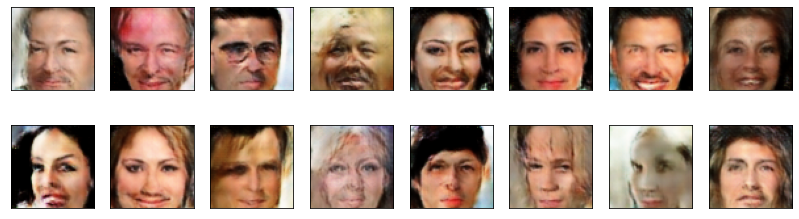

2023-12-21 10:32:05 | Epoch [11/30] | Batch 0/254 | d_loss: 0.8452 | g_loss: 2.0384
2023-12-21 10:32:59 | Epoch [11/30] | Batch 50/254 | d_loss: 1.0937 | g_loss: 0.9947
2023-12-21 10:33:53 | Epoch [11/30] | Batch 100/254 | d_loss: 0.8406 | g_loss: 1.0138
2023-12-21 10:34:48 | Epoch [11/30] | Batch 150/254 | d_loss: 0.9218 | g_loss: 1.9166
2023-12-21 10:35:43 | Epoch [11/30] | Batch 200/254 | d_loss: 1.0353 | g_loss: 1.2748
2023-12-21 10:36:37 | Epoch [11/30] | Batch 250/254 | d_loss: 1.2489 | g_loss: 1.9500


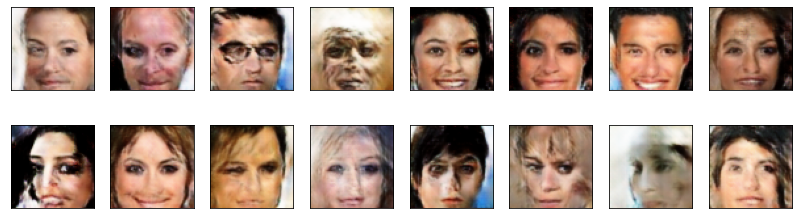

2023-12-21 10:36:45 | Epoch [12/30] | Batch 0/254 | d_loss: 0.9750 | g_loss: 1.6898
2023-12-21 10:37:40 | Epoch [12/30] | Batch 50/254 | d_loss: 0.8896 | g_loss: 1.7254
2023-12-21 10:38:34 | Epoch [12/30] | Batch 100/254 | d_loss: 1.1198 | g_loss: 1.4442
2023-12-21 10:39:28 | Epoch [12/30] | Batch 150/254 | d_loss: 1.1368 | g_loss: 1.3617
2023-12-21 10:40:23 | Epoch [12/30] | Batch 200/254 | d_loss: 1.2474 | g_loss: 1.1333
2023-12-21 10:41:17 | Epoch [12/30] | Batch 250/254 | d_loss: 1.2617 | g_loss: 2.8197


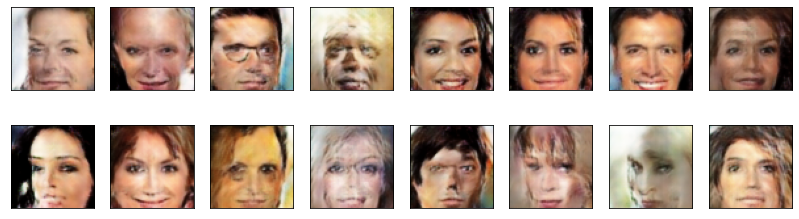

2023-12-21 10:41:25 | Epoch [13/30] | Batch 0/254 | d_loss: 0.9107 | g_loss: 2.3994
2023-12-21 10:42:19 | Epoch [13/30] | Batch 50/254 | d_loss: 0.8631 | g_loss: 2.4447
2023-12-21 10:43:14 | Epoch [13/30] | Batch 100/254 | d_loss: 1.1088 | g_loss: 2.8042
2023-12-21 10:44:08 | Epoch [13/30] | Batch 150/254 | d_loss: 0.9547 | g_loss: 1.7827
2023-12-21 10:45:03 | Epoch [13/30] | Batch 200/254 | d_loss: 1.0216 | g_loss: 1.3623
2023-12-21 10:45:57 | Epoch [13/30] | Batch 250/254 | d_loss: 1.2839 | g_loss: 2.1807


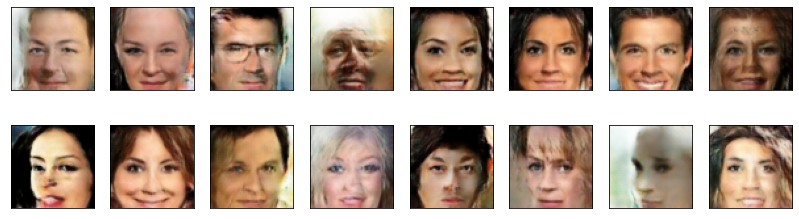

2023-12-21 10:46:05 | Epoch [14/30] | Batch 0/254 | d_loss: 0.8764 | g_loss: 1.7241
2023-12-21 10:46:59 | Epoch [14/30] | Batch 50/254 | d_loss: 1.1808 | g_loss: 1.3891
2023-12-21 10:47:54 | Epoch [14/30] | Batch 100/254 | d_loss: 1.0886 | g_loss: 1.2309
2023-12-21 10:48:48 | Epoch [14/30] | Batch 150/254 | d_loss: 1.1016 | g_loss: 2.5607
2023-12-21 10:49:43 | Epoch [14/30] | Batch 200/254 | d_loss: 0.9903 | g_loss: 2.7487
2023-12-21 10:50:37 | Epoch [14/30] | Batch 250/254 | d_loss: 1.1422 | g_loss: 2.9130


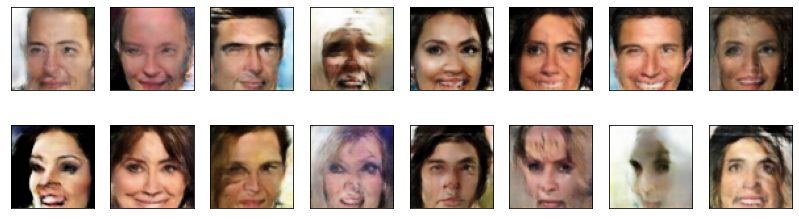

2023-12-21 10:50:45 | Epoch [15/30] | Batch 0/254 | d_loss: 1.1468 | g_loss: 2.5697
2023-12-21 10:51:39 | Epoch [15/30] | Batch 50/254 | d_loss: 0.9771 | g_loss: 3.6912
2023-12-21 10:52:33 | Epoch [15/30] | Batch 100/254 | d_loss: 1.0303 | g_loss: 2.8470
2023-12-21 10:53:28 | Epoch [15/30] | Batch 150/254 | d_loss: 0.9146 | g_loss: 3.0132
2023-12-21 10:54:22 | Epoch [15/30] | Batch 200/254 | d_loss: 0.8434 | g_loss: 1.6493
2023-12-21 10:55:17 | Epoch [15/30] | Batch 250/254 | d_loss: 1.7214 | g_loss: 1.0515


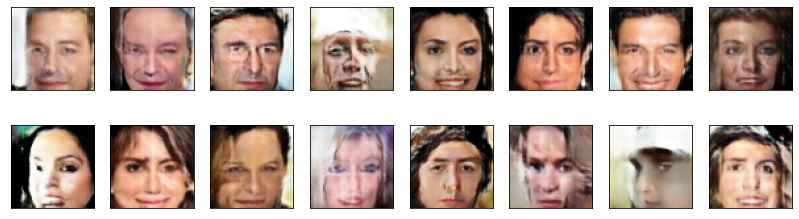

2023-12-21 10:55:25 | Epoch [16/30] | Batch 0/254 | d_loss: 1.1000 | g_loss: 1.4609
2023-12-21 10:56:20 | Epoch [16/30] | Batch 50/254 | d_loss: 0.7943 | g_loss: 1.6182
2023-12-21 10:57:14 | Epoch [16/30] | Batch 100/254 | d_loss: 1.0106 | g_loss: 2.9386
2023-12-21 10:58:09 | Epoch [16/30] | Batch 150/254 | d_loss: 1.0013 | g_loss: 2.1160
2023-12-21 10:59:04 | Epoch [16/30] | Batch 200/254 | d_loss: 0.9187 | g_loss: 1.6426
2023-12-21 10:59:58 | Epoch [16/30] | Batch 250/254 | d_loss: 1.1394 | g_loss: 3.0501


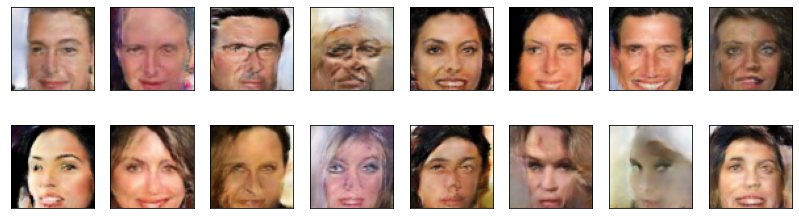

2023-12-21 11:00:06 | Epoch [17/30] | Batch 0/254 | d_loss: 1.0377 | g_loss: 2.7819
2023-12-21 11:01:01 | Epoch [17/30] | Batch 50/254 | d_loss: 1.0774 | g_loss: 0.8216
2023-12-21 11:01:55 | Epoch [17/30] | Batch 100/254 | d_loss: 1.0826 | g_loss: 1.3377
2023-12-21 11:02:49 | Epoch [17/30] | Batch 150/254 | d_loss: 0.9417 | g_loss: 1.3565
2023-12-21 11:03:44 | Epoch [17/30] | Batch 200/254 | d_loss: 1.5694 | g_loss: 1.1076
2023-12-21 11:04:38 | Epoch [17/30] | Batch 250/254 | d_loss: 1.2743 | g_loss: 3.6388


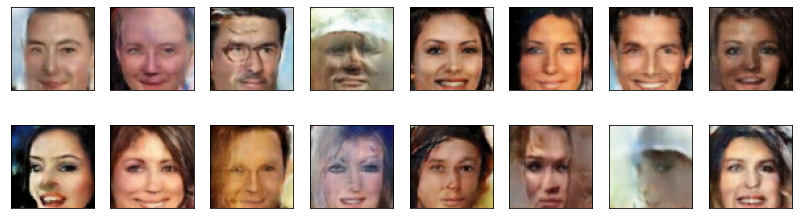

2023-12-21 11:04:45 | Epoch [18/30] | Batch 0/254 | d_loss: 0.9208 | g_loss: 2.5431
2023-12-21 11:05:40 | Epoch [18/30] | Batch 50/254 | d_loss: 1.0110 | g_loss: 2.3279
2023-12-21 11:06:34 | Epoch [18/30] | Batch 100/254 | d_loss: 0.8163 | g_loss: 1.5572
2023-12-21 11:07:29 | Epoch [18/30] | Batch 150/254 | d_loss: 0.9161 | g_loss: 1.8580
2023-12-21 11:08:23 | Epoch [18/30] | Batch 200/254 | d_loss: 1.0946 | g_loss: 2.7973
2023-12-21 11:09:18 | Epoch [18/30] | Batch 250/254 | d_loss: 1.1779 | g_loss: 2.0919


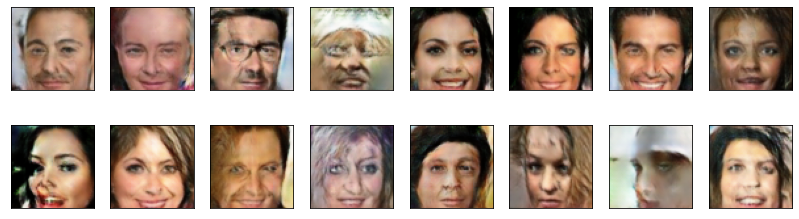

2023-12-21 11:09:26 | Epoch [19/30] | Batch 0/254 | d_loss: 0.9338 | g_loss: 1.9129
2023-12-21 11:10:20 | Epoch [19/30] | Batch 50/254 | d_loss: 0.9173 | g_loss: 1.4418
2023-12-21 11:11:15 | Epoch [19/30] | Batch 100/254 | d_loss: 1.4874 | g_loss: 4.8159
2023-12-21 11:12:09 | Epoch [19/30] | Batch 150/254 | d_loss: 1.4292 | g_loss: 3.7257
2023-12-21 11:13:03 | Epoch [19/30] | Batch 200/254 | d_loss: 1.1002 | g_loss: 2.6938
2023-12-21 11:13:57 | Epoch [19/30] | Batch 250/254 | d_loss: 0.9986 | g_loss: 1.3512


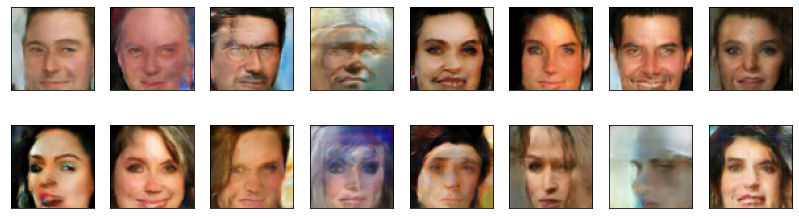

2023-12-21 11:14:05 | Epoch [20/30] | Batch 0/254 | d_loss: 0.9502 | g_loss: 3.7126
2023-12-21 11:15:00 | Epoch [20/30] | Batch 50/254 | d_loss: 0.7812 | g_loss: 2.5442
2023-12-21 11:15:54 | Epoch [20/30] | Batch 100/254 | d_loss: 0.9354 | g_loss: 1.9260
2023-12-21 11:16:48 | Epoch [20/30] | Batch 150/254 | d_loss: 0.8153 | g_loss: 1.5212
2023-12-21 11:17:43 | Epoch [20/30] | Batch 200/254 | d_loss: 0.8011 | g_loss: 2.1486
2023-12-21 11:18:37 | Epoch [20/30] | Batch 250/254 | d_loss: 1.1691 | g_loss: 2.7385


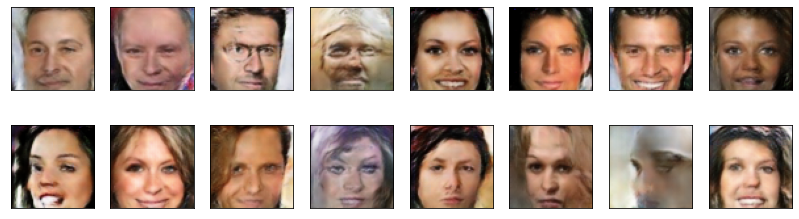

2023-12-21 11:18:45 | Epoch [21/30] | Batch 0/254 | d_loss: 0.8388 | g_loss: 2.1236
2023-12-21 11:19:40 | Epoch [21/30] | Batch 50/254 | d_loss: 0.9191 | g_loss: 1.4210
2023-12-21 11:20:34 | Epoch [21/30] | Batch 100/254 | d_loss: 0.8911 | g_loss: 1.3693
2023-12-21 11:21:29 | Epoch [21/30] | Batch 150/254 | d_loss: 1.7246 | g_loss: 4.0356
2023-12-21 11:22:23 | Epoch [21/30] | Batch 200/254 | d_loss: 1.1529 | g_loss: 3.1582
2023-12-21 11:23:18 | Epoch [21/30] | Batch 250/254 | d_loss: 1.1634 | g_loss: 3.0668


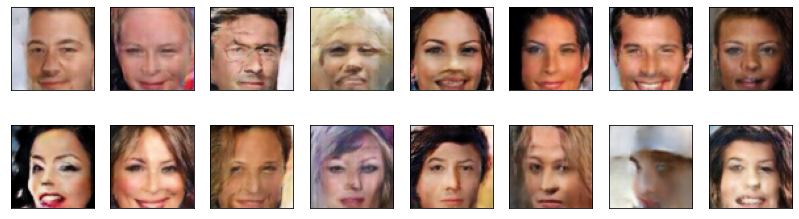

2023-12-21 11:23:26 | Epoch [22/30] | Batch 0/254 | d_loss: 0.8653 | g_loss: 1.7127
2023-12-21 11:24:21 | Epoch [22/30] | Batch 50/254 | d_loss: 0.8159 | g_loss: 2.3753
2023-12-21 11:25:15 | Epoch [22/30] | Batch 100/254 | d_loss: 0.9270 | g_loss: 1.1788
2023-12-21 11:26:09 | Epoch [22/30] | Batch 150/254 | d_loss: 1.1784 | g_loss: 1.0628
2023-12-21 11:27:03 | Epoch [22/30] | Batch 200/254 | d_loss: 0.9847 | g_loss: 2.9677
2023-12-21 11:27:58 | Epoch [22/30] | Batch 250/254 | d_loss: 0.8414 | g_loss: 2.3287


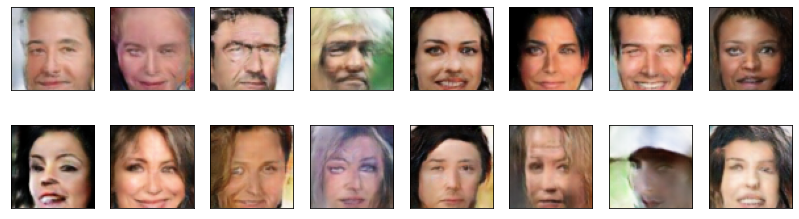

2023-12-21 11:28:06 | Epoch [23/30] | Batch 0/254 | d_loss: 0.7593 | g_loss: 1.6928
2023-12-21 11:29:00 | Epoch [23/30] | Batch 50/254 | d_loss: 1.1843 | g_loss: 3.3066
2023-12-21 11:29:54 | Epoch [23/30] | Batch 100/254 | d_loss: 0.9671 | g_loss: 1.6861
2023-12-21 11:30:48 | Epoch [23/30] | Batch 150/254 | d_loss: 0.7659 | g_loss: 2.1484
2023-12-21 11:31:43 | Epoch [23/30] | Batch 200/254 | d_loss: 1.0265 | g_loss: 1.3668
2023-12-21 11:32:37 | Epoch [23/30] | Batch 250/254 | d_loss: 0.8897 | g_loss: 1.3152


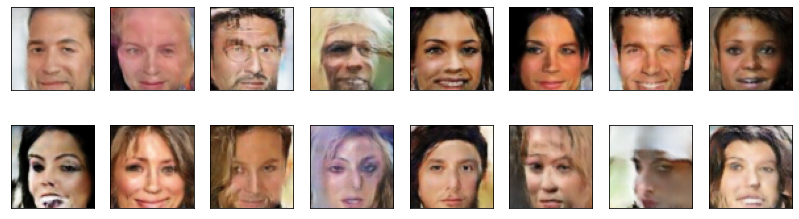

2023-12-21 11:32:45 | Epoch [24/30] | Batch 0/254 | d_loss: 1.3727 | g_loss: 1.5145
2023-12-21 11:33:39 | Epoch [24/30] | Batch 50/254 | d_loss: 1.2814 | g_loss: 4.2320
2023-12-21 11:34:34 | Epoch [24/30] | Batch 100/254 | d_loss: 0.8963 | g_loss: 1.5452
2023-12-21 11:35:28 | Epoch [24/30] | Batch 150/254 | d_loss: 0.9086 | g_loss: 2.4654
2023-12-21 11:36:26 | Epoch [24/30] | Batch 200/254 | d_loss: 0.8279 | g_loss: 2.9274
2023-12-21 11:37:23 | Epoch [24/30] | Batch 250/254 | d_loss: 0.8947 | g_loss: 1.5594


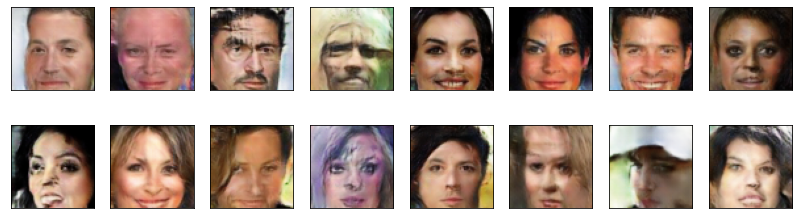

2023-12-21 11:37:31 | Epoch [25/30] | Batch 0/254 | d_loss: 0.8180 | g_loss: 2.2780
2023-12-21 11:38:29 | Epoch [25/30] | Batch 50/254 | d_loss: 0.9630 | g_loss: 3.1689
2023-12-21 11:39:26 | Epoch [25/30] | Batch 100/254 | d_loss: 0.9198 | g_loss: 3.2426
2023-12-21 11:40:21 | Epoch [25/30] | Batch 150/254 | d_loss: 0.8743 | g_loss: 3.3913
2023-12-21 11:41:16 | Epoch [25/30] | Batch 200/254 | d_loss: 0.7687 | g_loss: 2.2938
2023-12-21 11:42:10 | Epoch [25/30] | Batch 250/254 | d_loss: 0.6961 | g_loss: 1.8152


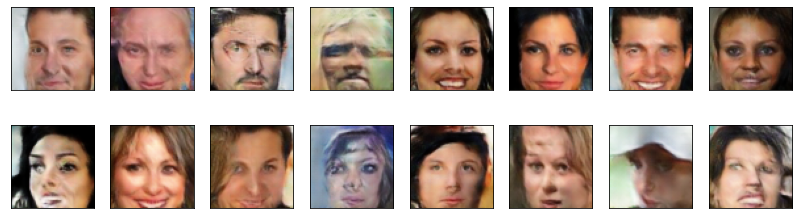

2023-12-21 11:42:18 | Epoch [26/30] | Batch 0/254 | d_loss: 0.7865 | g_loss: 2.3764
2023-12-21 11:43:12 | Epoch [26/30] | Batch 50/254 | d_loss: 1.0724 | g_loss: 1.3804
2023-12-21 11:44:06 | Epoch [26/30] | Batch 100/254 | d_loss: 0.6185 | g_loss: 2.0653
2023-12-21 11:45:01 | Epoch [26/30] | Batch 150/254 | d_loss: 0.8369 | g_loss: 3.1237
2023-12-21 11:45:55 | Epoch [26/30] | Batch 200/254 | d_loss: 0.7803 | g_loss: 3.9198
2023-12-21 11:46:50 | Epoch [26/30] | Batch 250/254 | d_loss: 0.8855 | g_loss: 2.1117


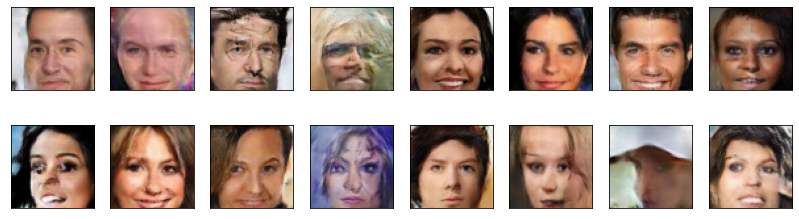

2023-12-21 11:46:58 | Epoch [27/30] | Batch 0/254 | d_loss: 0.6560 | g_loss: 2.0449
2023-12-21 11:47:52 | Epoch [27/30] | Batch 50/254 | d_loss: 0.7663 | g_loss: 1.5436
2023-12-21 11:48:47 | Epoch [27/30] | Batch 100/254 | d_loss: 0.8444 | g_loss: 2.9019
2023-12-21 11:49:41 | Epoch [27/30] | Batch 150/254 | d_loss: 0.7873 | g_loss: 2.0888
2023-12-21 11:50:35 | Epoch [27/30] | Batch 200/254 | d_loss: 0.8408 | g_loss: 3.4451
2023-12-21 11:51:29 | Epoch [27/30] | Batch 250/254 | d_loss: 1.0302 | g_loss: 1.3090


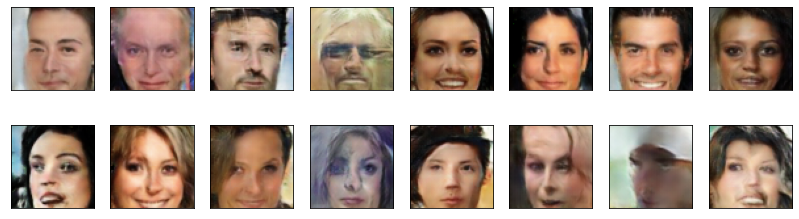

2023-12-21 11:51:37 | Epoch [28/30] | Batch 0/254 | d_loss: 0.7004 | g_loss: 2.5147
2023-12-21 11:52:32 | Epoch [28/30] | Batch 50/254 | d_loss: 1.1897 | g_loss: 1.3303
2023-12-21 11:53:26 | Epoch [28/30] | Batch 100/254 | d_loss: 0.8800 | g_loss: 1.6097
2023-12-21 11:54:21 | Epoch [28/30] | Batch 150/254 | d_loss: 0.9179 | g_loss: 3.9172
2023-12-21 11:55:15 | Epoch [28/30] | Batch 200/254 | d_loss: 0.9010 | g_loss: 3.0072
2023-12-21 11:56:09 | Epoch [28/30] | Batch 250/254 | d_loss: 0.8327 | g_loss: 2.7999


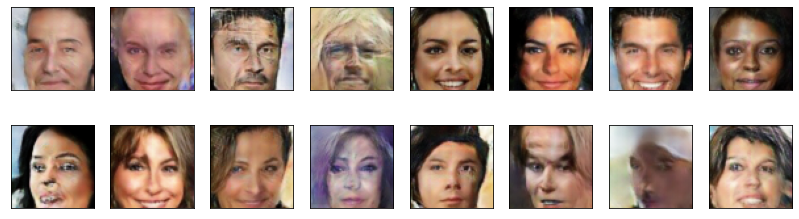

2023-12-21 11:56:18 | Epoch [29/30] | Batch 0/254 | d_loss: 0.6032 | g_loss: 2.1077
2023-12-21 11:57:12 | Epoch [29/30] | Batch 50/254 | d_loss: 0.7880 | g_loss: 1.4490
2023-12-21 11:58:06 | Epoch [29/30] | Batch 100/254 | d_loss: 0.7322 | g_loss: 2.1415
2023-12-21 11:59:01 | Epoch [29/30] | Batch 150/254 | d_loss: 1.1787 | g_loss: 1.2389
2023-12-21 11:59:55 | Epoch [29/30] | Batch 200/254 | d_loss: 0.9230 | g_loss: 3.3521
2023-12-21 12:00:50 | Epoch [29/30] | Batch 250/254 | d_loss: 0.8432 | g_loss: 1.4885


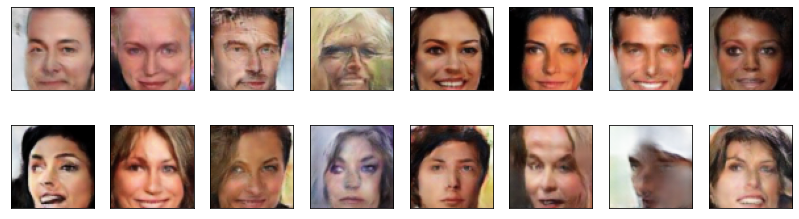

2023-12-21 12:00:58 | Epoch [30/30] | Batch 0/254 | d_loss: 0.7533 | g_loss: 1.9714
2023-12-21 12:01:53 | Epoch [30/30] | Batch 50/254 | d_loss: 0.7950 | g_loss: 1.2949
2023-12-21 12:02:47 | Epoch [30/30] | Batch 100/254 | d_loss: 0.9285 | g_loss: 1.4134
2023-12-21 12:03:41 | Epoch [30/30] | Batch 150/254 | d_loss: 0.7548 | g_loss: 2.2275
2023-12-21 12:04:36 | Epoch [30/30] | Batch 200/254 | d_loss: 0.6405 | g_loss: 2.2232
2023-12-21 12:05:30 | Epoch [30/30] | Batch 250/254 | d_loss: 1.0197 | g_loss: 1.3969


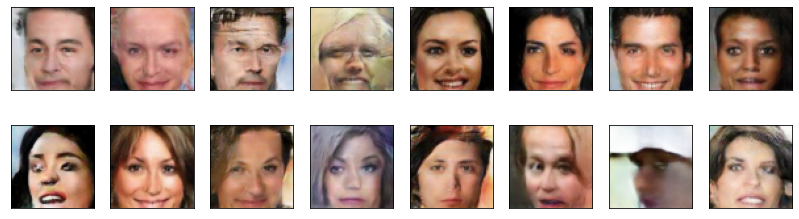

In [27]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        d_loss = discriminator_step(batch_size=batch_size, latent_dim= latent_dim, real_images=real_images) 
        g_loss = generator_step(batch_size=batch_size, latent_dim= latent_dim)
                        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

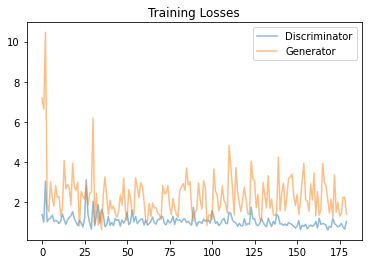

In [28]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (The samples generated are starting to outline the face traits. On one hand, training a WGAN-GP needs a very careful balance of the hyperparameters to avoid either the Generator or the Discriminator to win immediately. On the other hand, the time to train the model for 50 epochs is already quite extensive. What is evident is that, training for more than 50 epochs should provide better results. If the learning rate of the Generator is not small enough, the Discriminator might end up winning in the mid of the training making the model inference collapsing. What has been furtherly noticed is that increasing the number of neurons in the convolutional block leads to longer training time, but not necessarily to better results at parity of training epochs. To have a faster training, it might be better to have a better function to generate a sufficiently sparse noise latent vector. The dimension of the latent vector also help to regulate and avoid overtraining. Instead, to generate better results, likely a more complicated GAN structure is required)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.